In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from sklearn.svm import LinearSVC
import random
import json
import shutil

In [3]:
proj_path = '/content/drive/MyDrive/cs539_project/'
train_path = 'lfw-deepfunneled-train/'
test_path = 'lfw-deepfunneled-test/'

In [4]:
def count_image(name):
  dir = os.path.join(proj_path, 'lfw-deepfunneled', name)
  images = os.listdir(dir)
  if '.DS_Store' in images:
    images.remove('.DS_Store')
  return images

In [5]:
if 'people.txt' not in os.listdir(proj_path):
  l = os.listdir(proj_path + 'lfw-deepfunneled')
  l.remove('.DS_Store')
  counts = {}
  for name in l:
    images = count_image(name)
    if len(images) > 20:
      counts[name] = [images, int(np.ceil(len(images)*0.2))]

  with open(proj_path + 'people.txt', 'w') as f:
    f.write(json.dumps(counts))

In [6]:
with open(proj_path + 'people.txt', 'r') as f:
  s = f.read()
  counts = json.loads(s)
len(counts)

57

In [7]:
if 'lfw-deepfunneled-train' not in os.listdir(proj_path):
  os.mkdir(proj_path + train_path)
  os.mkdir(proj_path + test_path)
  for name in counts.keys():
    os.mkdir(os.path.join(proj_path, test_path, name))
    samples = counts[name][0]
    test_size = counts[name][1]
    test_samples = random.sample(samples, k=test_size)
    shutil.copytree(os.path.join(proj_path, 'lfw-deepfunneled',name), os.path.join(proj_path, train_path, name))
    for sample in test_samples:
      os.rename(os.path.join(proj_path, train_path, name, sample), os.path.join(proj_path, test_path, name, sample))

# Preprocessing Data

(250, 250, 3)


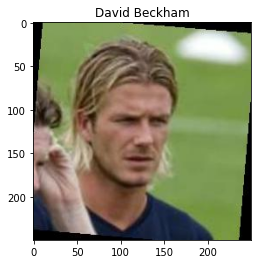

In [8]:
# Look at arbitrary images in the training set
for dirName, subdirList, fileList in os.walk(proj_path + 'lfw-deepfunneled-train/David_Beckham'):
    f = fileList[0]
    img = cv2.imread(os.path.join(dirName, f))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    print(img.shape)
    plt.imshow(img)
    plt.title(' '.join(dirName.split('/')[-1].split('_')))

In [9]:
def load_and_align_images(images, margin=10):
  cascade = cv2.CascadeClassifier(proj_path + 'haarcascade_frontalface_alt2.xml')

  aligned_faces = []
  for img in images:
    img = np.array(img, dtype='uint8')
    faces = cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=3)
    if len(faces) == 0:
      cropped = img[61:189, 61:189, :]
    else:
      (x, y, w, h) = faces[0]
      cropped = img[max(0,y-margin//2):y+h+margin//2,
                    max(0,x-margin//2):x+w+margin//2, :]
    aligned = resize(cropped, (160, 160), mode='reflect')
    aligned_faces.append(aligned)
      
  return aligned_faces

In [10]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [11]:
images_train = []
labels_train = []
for name in os.listdir(os.path.join(proj_path, train_path)):
  for i in os.listdir(os.path.join(proj_path, train_path, name)):
    image = cv2.imread(os.path.join(proj_path, train_path, name, i))
    images_train.append(image)
    labels_train.append(name)

In [12]:
images_test = []
labels_test = []
for name in os.listdir(os.path.join(proj_path, test_path)):
  for i in os.listdir(os.path.join(proj_path, test_path, name)):
    image = cv2.imread(os.path.join(proj_path, test_path, name, i))
    images_test.append(image)
    labels_test.append(name)

In [13]:
aligned_train = load_and_align_images(images_train)
aligned_test = load_and_align_images(images_test)

In [14]:
pwaligned_train = prewhiten(np.array(aligned_train))
pwaligned_test = prewhiten(np.array(aligned_test))



# Embeddings

In [15]:
net = load_model(proj_path + 'facenet_keras.h5')

In [16]:
def triplet_loss(y_true, y_pred, alpha = 0.3):    
  anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]    
  pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)), axis=-1)
  neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
  basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
  loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
  return loss

In [17]:
net.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

In [18]:
embs_train = net.predict(pwaligned_train)
embs_test = net.predict(pwaligned_test)

In [19]:
norm_embs_train = l2_normalize(embs_train)
norm_embs_test = l2_normalize(embs_test)

# Classification

In [20]:
le = LabelEncoder().fit(labels_train)
y_train = le.transform(labels_train)
y_test = le.transform(labels_test)

In [21]:
clf = LinearSVC()
clf.fit(norm_embs_train, y_train)

LinearSVC()

In [29]:
# Training Accuracy
clf.score(norm_embs_train, y_train)

0.9865916955017301

In [30]:
# Testing Accuracy
clf.score(norm_embs_test, y_test)

0.9787234042553191

In [24]:
y_pred = le.inverse_transform(clf.predict(norm_embs_test))

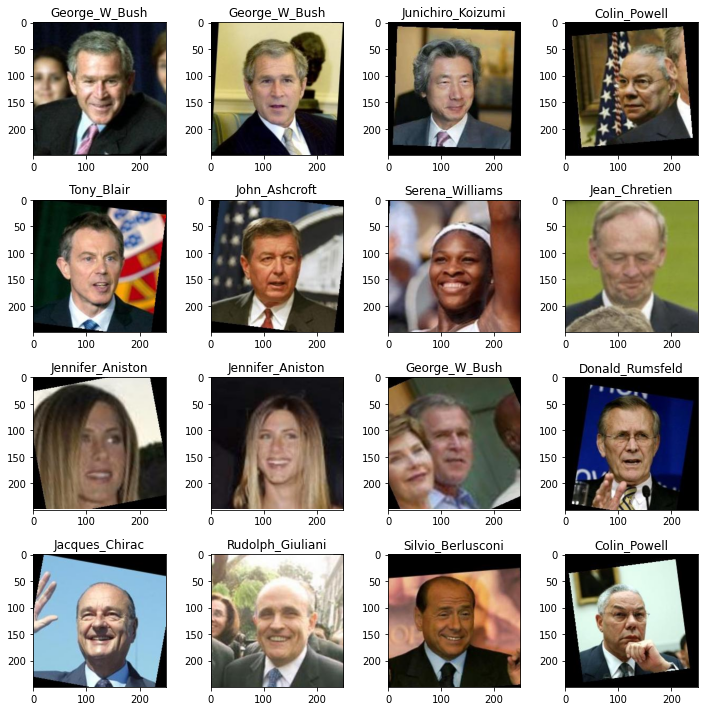

In [28]:
fig, ax = plt.subplots(4,4, figsize=(10,10))
fig.tight_layout()
for row in range(4):
  for col in range(4):
    rand = np.random.randint(0, len(images_test))
    ax[row][col].imshow(cv2.cvtColor(images_test[rand], cv2.COLOR_BGR2RGB))
    ax[row][col].title.set_text(y_pred[rand])